In [1]:
import keras
from keras.preprocessing import image
from skimage.feature import canny 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sys
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
import cv2
import keras.backend as K
from skimage import color
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")



**Load the dataset**

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv') #Train data input
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv') #Test data input

In [3]:
train_y = train["diagnosis"]

**Dataset Visualisation**

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

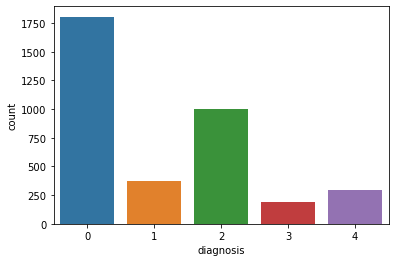

In [4]:
# Label wise distribution of data
sns.countplot(x="diagnosis", data=train)

In [5]:
#Let's see the size of an image in train and test dataset
image1 = cv2.imread(f"../input/aptos2019-blindness-detection/train_images/{train['id_code'][1000]}.png")
image1.shape

(2136, 3216, 3)

##### Display 5 images from each class

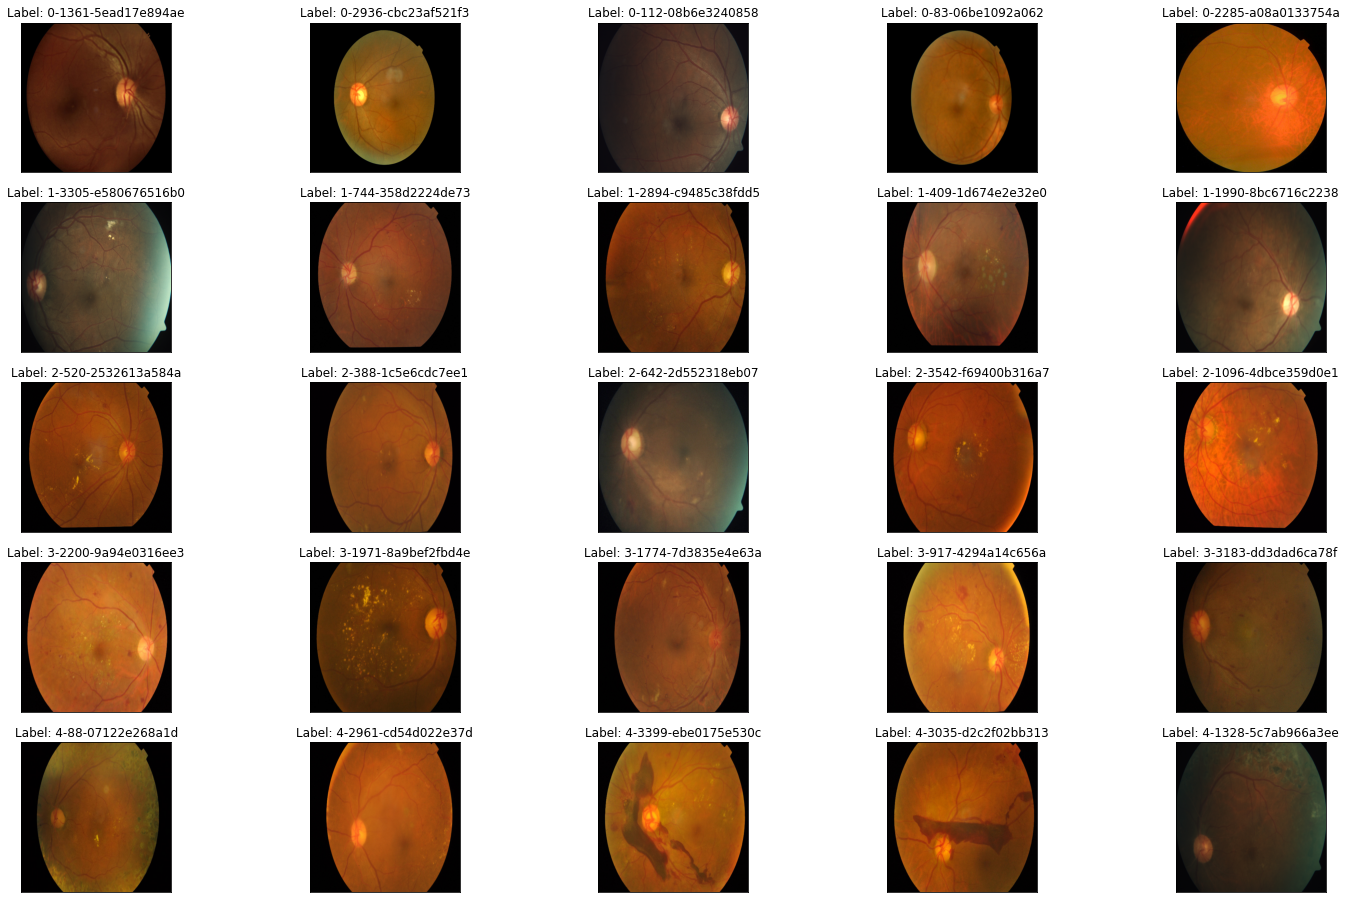

In [6]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        ax = fig.add_subplot(5, 5, class_id*5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

##### Display Gray Scaled Gaussian Weighted 5 images from each class

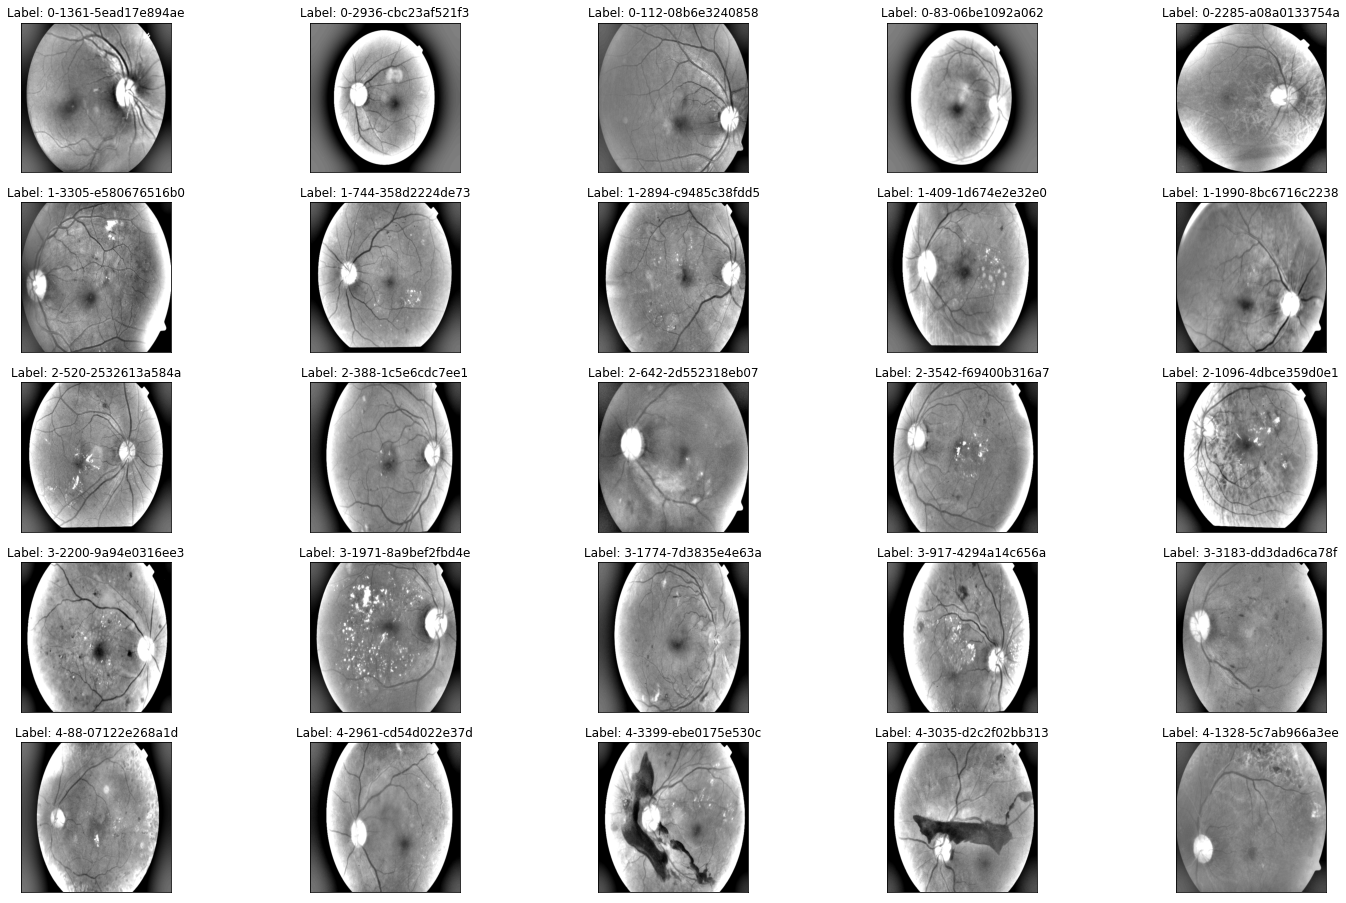

In [7]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (512, 512))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128)
        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

##### Function to crop grayscaled images

In [8]:
def crop_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape != 0):
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1) 
        else:
            return img
        return img


##### Function to Crop colored images 

In [10]:
def crop_image(img, sigmaX):   
    img = cv2.imread(img)
    img = crop_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    new_img = np.zeros((height, width), np.uint8)
    cv2.circle(new_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=new_img)
    img = crop_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

##### Function to plot edges from images

In [11]:
def edge_Detect(img):
    img = color.rgb2gray(img) 
    edges = canny(img) 
    return edges

##### Trying crop_image on the sample image set 

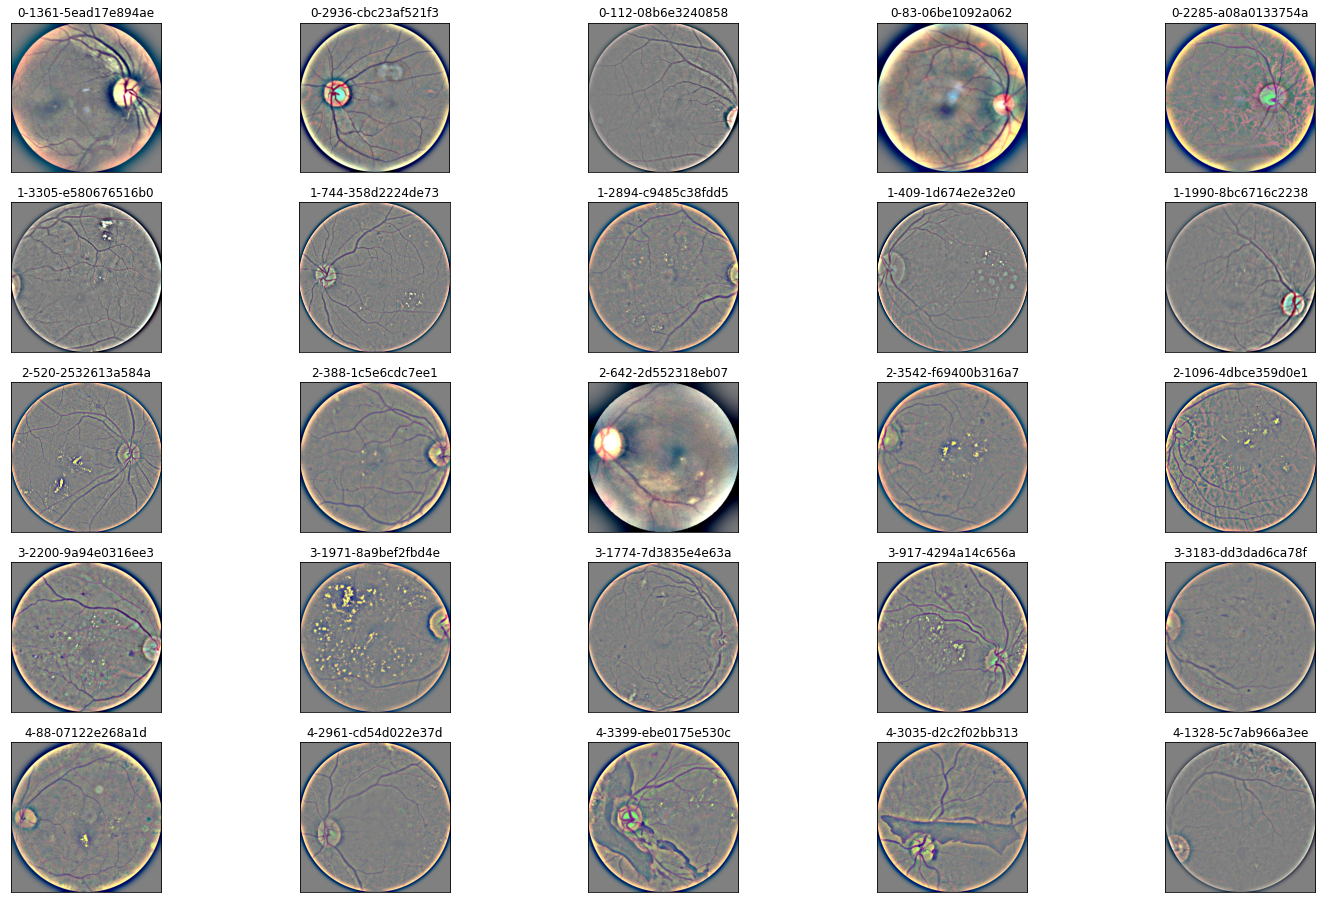

In [12]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = crop_image(path,30)
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

##### Display crop images only edges (Edge Detection)

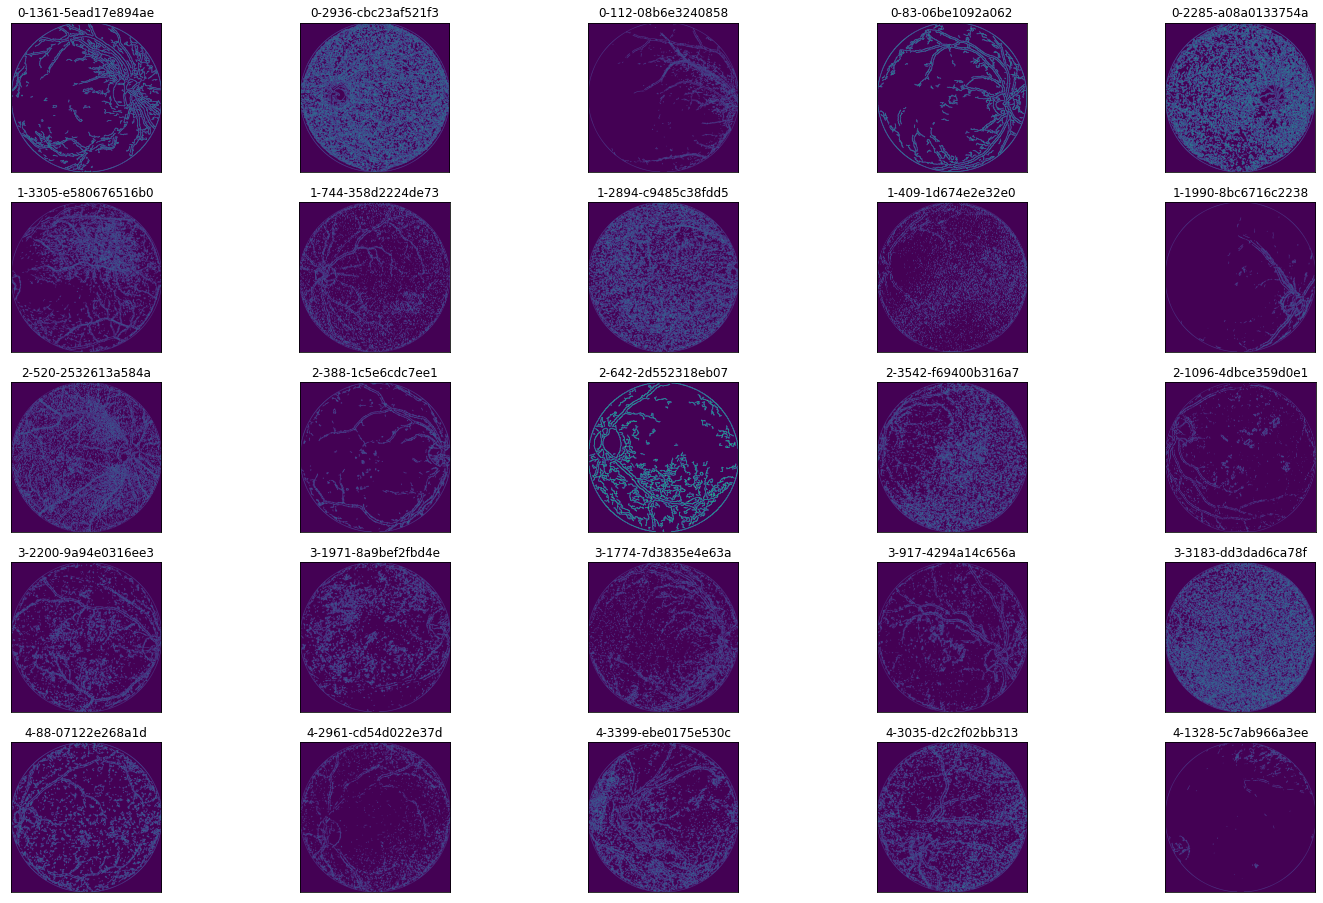

In [13]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = crop_image(path,30)
        image = edge_Detect(image)
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )